### Import Statements

In [1]:
import requests
import fitz  # PyMuPDF
import contextlib
import re
import torch
import numpy as np
import os
from numpy.typing import ArrayLike

### Model loading

Loading the pytorch version of Gemma 7b Instruct (int8 quantized)

In [5]:
from gemma.config import get_config_for_7b
from gemma.model import GemmaForCausalLM

# Utilizes: 12.7 GB VRAM, ~ 24 GB RAM at peak
def gemma_call(prompt: str):

  VARIANT = "7b-it-quant" 
  MACHINE_TYPE = "cuda" 
  weights_dir = 'gemma/7b-it-quant/' 

  @contextlib.contextmanager
  def _set_default_tensor_type(dtype: torch.dtype):
    """Sets the default torch dtype to the given dtype."""
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(torch.float)

  # Model Config
  model_config = get_config_for_7b() if "7b" in VARIANT else print('Download required.')
  model_config.tokenizer = os.path.join(weights_dir, "tokenizer.model")
  model_config.quant = "quant" in VARIANT

  # Model
  device = torch.device(MACHINE_TYPE)
  with _set_default_tensor_type(model_config.get_dtype()):
    model = GemmaForCausalLM(model_config)
    ckpt_path = os.path.join(weights_dir, f'gemma-7b-quant.ckpt')
    model.load_weights(ckpt_path)
    model = model.to(device).eval()

  USER_CHAT_TEMPLATE = "<start_of_turn>user\n{prompt}<end_of_turn>\n"
  MODEL_CHAT_TEMPLATE = "<start_of_turn>model\n{prompt}<end_of_turn>\n"

  model_input = (
    USER_CHAT_TEMPLATE.format(prompt=prompt)
    + "<start_of_turn>model\nSure here it is:"
  )

  print(model_input)

  answer = model.generate(
      model_input,
      device=device,
      output_len=100, 
      temperature=0.1,
      top_p=0.5, 
      top_k=20, 
  )

  torch.cuda.empty_cache()
  return answer

### Data Retriaval
Download of the pdf file(s)

In [2]:
pdf_url = "https://bugs.python.org/file47781/Tutorial_EDIT.pdf"

def download_pdf(url):
    response = requests.get(url)
    with open('temp.pdf', 'wb') as f:
        f.write(response.content)
    return 'temp.pdf'

def pdf_to_text(filename):
    doc = fitz.open(filename)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

def clean_text(text):
    # Remove double spaces
    return re.sub(' +', ' ', text)

def split_text_into_chunks(text, num_chunks):
    words = text.split()
    total_words = len(words)
    chunk_size = total_words // num_chunks
    chunks = [' '.join(words[i * chunk_size : (i + 1) * chunk_size]) for i in range(num_chunks)]
    return chunks

pdf_file = download_pdf(pdf_url)
pdf_text = pdf_to_text(pdf_file)
clean_pdf_text = clean_text(pdf_text)

# Decide on the number of chunks you want
num_chunks = 200
chunks = split_text_into_chunks(clean_pdf_text, num_chunks)

# This will print the chunks, you can process them further as needed
for i, chunk in enumerate(chunks, 1):
    print(f"Chunk {i}: {chunk[:100]}...")  # Printing the first 100 characters of each chunk for brevity


Chunk 1: Python Tutorial Release 3.7.0 Guido van Rossum and the Python development team September 02, 2018 Py...
Chunk 2: 19 4.2 for Statements . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ...
Chunk 3: . 24 4.8 Intermezzo: Coding Style . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ...
Chunk 4: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 38 5.6 Looping Techniques . . ...
Chunk 5: . . . 46 6.3 The dir() Function . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ...
Chunk 6: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 61 8.3 Handling Exceptions ....
Chunk 7: 69 9.1 A Word About Names and Objects . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ...
Chunk 8: . . . . . . . . . . . . 78 9.7 Odds and Ends . . . . . . . . . . . . . . . . . . . . . . . . . . . ....
Chunk 9: File Wildcards . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### Data Cleaning
Using the 7B instruct model

In [3]:
from mlx_lm import load, generate

model, tokenizer = load("mlx-community/quantized-gemma-7b-it")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Calculate the differences between original and cleaned lengths
differences = []
new_data = []
for chunk in tqdm(chunks, desc="Calculating differences"):
    prompt = f"<start_of_turn>user Clean the following data so that only relevant content remains and unneccessary signs are removed. Do not make stuff up on your own: {chunk} <start_of_turn>model Sure, here is the cleaned data:"
    response = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=2000)
    differences.append(len(response) / len(chunk))
    new_data.append(response)

Calculating differences: 100%|██████████| 200/200 [20:30<00:00,  6.15s/it]


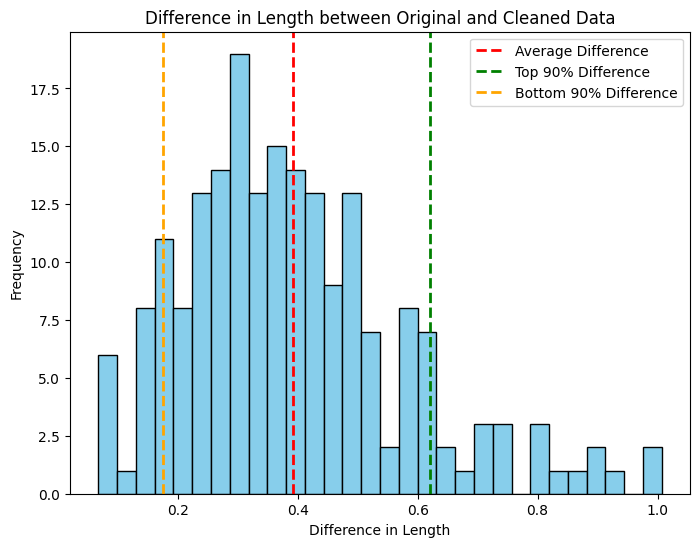

In [5]:
# Calculate the average difference
average_difference = np.mean(differences)

# Calculate the top and bottom 90% differences
top_90_percentile = np.percentile(differences, 90)
bottom_90_percentile = np.percentile(differences, 10)

# Plot the differences
plt.figure(figsize=(8, 6))
plt.hist(differences, bins=30, color='skyblue', edgecolor='black')
plt.axvline(average_difference, color='red', linestyle='dashed', linewidth=2, label='Average Difference')
plt.axvline(top_90_percentile, color='green', linestyle='dashed', linewidth=2, label='Top 90% Difference')
plt.axvline(bottom_90_percentile, color='orange', linestyle='dashed', linewidth=2, label='Bottom 90% Difference')
plt.xlabel('Difference in Length')
plt.ylabel('Frequency')
plt.title('Difference in Length between Original and Cleaned Data')
plt.legend()
plt.show()

In [6]:
import re
new_text = "\n".join(new_data)
chunks = split_text_into_chunks(new_text, int(num_chunks / 2))
# chunks = split_text_into_chunks(new_text, 5)

chapter_text = []
for chunk in tqdm(chunks, desc="Seperating into senseful chunks"):
    prompt = f"<start_of_turn>user Add /chapter at every headline, where a new chapter begins: {chunk} <start_of_turn>model Sure, here is the seperated text:"
    response = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=2000)
    chapter_text.append(response)

Seperating into senseful chunks:   0%|          | 0/100 [00:00<?, ?it/s]

Seperating into senseful chunks: 100%|██████████| 100/100 [13:44<00:00,  8.25s/it]


In [7]:
new_text = "\n".join(chapter_text)
# Split the text 2 indices before every mention of "chapter" into a list of strings
split_text = re.split(r"(?<=\bChapter\b)", new_text)

# Remove leading and trailing whitespaces from each string
split_text = [text.strip() for text in split_text]

### Embedding Function
for ChromaDB

In [8]:
import chromadb as db  # This helps us work with the vectors database
from chromadb.utils import embedding_functions  # This helps us fetch our embedding model
from chromadb import Documents, EmbeddingFunction, Embeddings
from sentence_transformers.util import cos_sim, dot_score

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import string

class Embedding(EmbeddingFunction):
    def __init__(self):
        self.embedding_model = embedding_functions.SentenceTransformerEmbeddingFunction('thenlper/gte-large')  # ("Salesforce/SFR-Embedding-Mistral") (7b)

    def encode(self, input: Documents) -> Embeddings:
        embeddings = self.embedding_model(input)
        return embeddings
    
    def __call__(self, input: Documents) -> Embeddings:
        embeddings = self.embedding_model(input)
        return embeddings

    def distance(self, x: ArrayLike, y: ArrayLike) -> float:
        return cos_sim(x, y)

    def plot(self, query: str, documents: Documents) -> None:
        query = query[0] if isinstance(query, list) and len(query) == 1 else query
        texts = [query] + documents if query else documents
        embeddings = self.encode(texts)
        tsne_results = TSNE(n_components=2, perplexity=min(30, len(embeddings) - 1)).fit_transform(np.array(embeddings))
        cluster_labels = DBSCAN(eps=0.9, min_samples=2).fit(tsne_results[1:]).labels_ if query else DBSCAN(eps=0.5, min_samples=2).fit(tsne_results).labels_

        plt.figure(figsize=(12, 8))
        plt.axis('off')
        if query:
            plt.scatter(tsne_results[0, 0], tsne_results[0, 1], c='red', label='Query', s=100)
            plt.annotate(query, (tsne_results[0, 0], tsne_results[0, 1]), fontsize=9, alpha=0.7, color='black')

        scatter = plt.scatter(tsne_results[1:, 0], tsne_results[1:, 1], c=cluster_labels, cmap='Pastel2', alpha=0.85)

        FILLER_WORDS = set([
            'the', 'and', 'a', 'to', 'of', 'in', 'i', 'is', 'that', 'on', 
            'for', 'it', 'with', 'as', 'this', 'by', 'are', 'be', 'was', 'or', 'you', 'an',
        ])

        # Find and annotate clusters with frequent words
        for label in set(cluster_labels):
            if label == -1:  # Ignore noise
                continue
            cluster_docs = [documents[i] for i, lbl in enumerate(cluster_labels) if lbl == label]
            words = ' '.join(cluster_docs).lower().split()
            words = [word.strip(string.punctuation) for word in words if word not in FILLER_WORDS and word.strip(string.punctuation) not in FILLER_WORDS]
            word_counts = Counter(words)
            most_common_words = ' '.join(word for word, count in word_counts.most_common(3))  # Get top 3 words

            cluster_center = np.mean([tsne_results[i + 1] for i, lbl in enumerate(cluster_labels) if lbl == label], axis=0)
            plt.annotate(most_common_words, (cluster_center[0], cluster_center[1]), fontsize=9, alpha=0.7, color='black')

        plt.grid(True, which='both', linestyle='--', linewidth=0.2)
        plt.show()

In [21]:
embedding_model = Embedding()

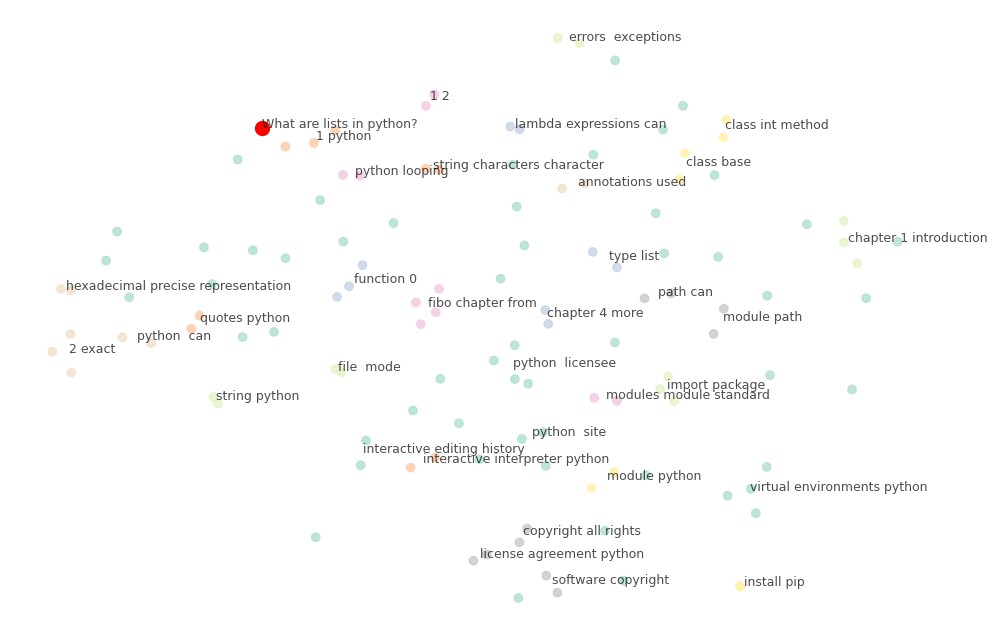

In [21]:
embedding_model.plot(["How does the interpreter search for and execute Python modules when they are run as scripts?"], split_text)

In [68]:
print(gemma_call('Please use 3 words to describe the following paragarph:\n\n' + ''.join(i for i in split_text_into_chunks(clean_pdf_text, 250)[40:41])+ '\n'))

<start_of_turn>user
Please use 3 words to describe the following paragarph:

writing the expression you want to write (as we did earlier in the calculator examples) in the way it handles multiple arguments, ﬂoating point quantities, and strings. Strings are printed without quotes, and a space is inserted between items, so you can format things nicely, like this: 16 Chapter 3. An Informal Introduction to Python Python Tutorial, Release 3.7.0 >>> i = 256*256 >>> print('The value of i is', i) The value of i is 65536 The keyword argument end can be used to avoid the newline after the output, or end the output with a diﬀerent string: >>> a, b = 0, 1 >>> while a < 1000: ... print(a, end=',') ... a, b = b, a+b ... 0,1,1,2,3,5,8,13,21,34,55,89,144,233,377,610,987, 3.2. First Steps Towards Programming 17 Python Tutorial, Release 3.7.0 18 Chapter 3. An Informal Introduction to Python CHAPTER FOUR MORE CONTROL FLOW TOOLS Besides the while statement just introduced, Python knows the usual control 

### Data Loading
Loading the data into ChromaDB

In [10]:
import chromadb
from chromadb.utils import embedding_functions # This helps us fetch our embedding model

client = chromadb.PersistentClient(path="./chromadb")

ids = [f"Tutorial_{i}" for i in range(len(split_text))]
metadata = [{"id": f"Tutorial_{i}"} for i in range(len(split_text))]

collection_exists = "Python-RAG" in [collection.name for collection in client.list_collections()]
if not collection_exists:
    collection = client.create_collection(
        name=f"Python-RAG",
        metadata={"hnsw:space": "cosine"}, # l2 is the default
        embedding_function=embedding_model,
    )
    collection.add(
        documents=split_text,
        metadatas=metadata,
        ids=ids,
    )
else:
    collection = client.get_collection("Python-RAG")

In [11]:
print(len(split_text))

121


### Benchmarking
Benchmarking the retrieval process by automatically generating specific questions for each chunk and testing, whether the right document is retrieved.

In [11]:
data = collection.get()
questions = []
for id, document in tqdm(zip(data["ids"], data["documents"]), desc="Generating questions"):
    prompt = f"<start_of_turn>user Create a specific question for this text: {document} <start_of_turn>model Sure, here is the question:"
    question = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=1000)
    question = question.replace("\n", "")
    question = question.replace("*", "")
    questions.append(question)

Generating questions: 121it [02:35,  1.29s/it]


In [12]:
import random
random_questions = random.sample(questions, 5)
for question in random_questions:
    print(question)

How does the random module in Python provide tools for making random selections?
What is the main topic of the text?
What is the main topic discussed in the text "Floating Point Arithmetic: Issues and Limitations"?
How does the Python interpreter typically be installed and started on machines where it is available?
How does the interpreter search for and execute Python modules when they are run as scripts?


In [13]:
accuracies = {}
lengths = [1, 2, 3, 4, 5]
for n_results in lengths:
    datapoints = []
    for id, question in zip(data["ids"], questions):
        results = collection.query(query_texts=question, n_results=n_results)
        result_ids = results["ids"][0]
        if id in result_ids:
            datapoints.append(1)
        else:
            datapoints.append(0)

    accuracies[n_results] = sum(datapoints) / len(datapoints)
accuracies

{1: 0.8347107438016529,
 2: 0.9008264462809917,
 3: 0.9338842975206612,
 4: 0.9504132231404959,
 5: 0.9504132231404959}

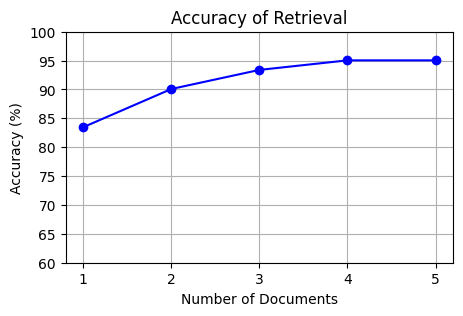

In [14]:
x = list(accuracies.keys())
y = [value * 100 for value in list(accuracies.values())]

plt.figure(figsize=(5, 3))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Retrieval')
plt.xlabel('Number of Documents')
plt.ylabel('Accuracy (%)')
plt.ylim(60, 100)  # Set y-axis limits to show percentages clearly
plt.grid(True)
plt.xticks(x)  # Ensure all x-axis values are shown
plt.show()

### RAG Class
Document retrieval and prompt engineering

In [15]:
class RAG:

    def __init__(self, model, tokenizer, collection) -> None:
        self.model = model
        self.tokenizer = tokenizer
        self.collection = collection

    def query(self, prompt, n_results=1):
        return self.collection.query(query_texts=prompt, n_results=n_results)
    
    def generate_text(self, prompt: str) -> str:
        result = self.collection.query(
            query_texts=prompt,
            n_results=3,
        )
        documents = ' '.join(result["documents"][0])
        prompt = f"<start_of_turn>user You are an assistant. Answer the following question based on the following knowledge base. Knowledge Base: {documents}\n Question: {prompt} <start_of_turn>model "
        output = generate(self.model, self.tokenizer, prompt=prompt, verbose=False, max_tokens=1000)
        return output

### LLM Generating Answers
Including a Chat Interface

In [20]:
rag = RAG(model, tokenizer, collection)
print(rag.generate_text("How does the interpreter search for and execute Python modules when they are run as scripts?"))



Sure, here is the answer to the question based on the knowledge base:

When a Python module is run as a script, the interpreter searches for the module in the built-in module directory and then in the directories specified by the variable sys.path. If the module is found, its code is executed. The directory containing the script being run is placed at the beginning of the search path, ahead of the standard library path, so scripts in that directory will be loaded instead of modules of the same name in the library directory.
